In [1]:
import numpy as np
np.random.seed(200)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GaussianNoise, UpSampling2D, LocallyConnected2D, RepeatVector
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import roc_curve, auc

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
matplotlib.rc('font', size=8)                   # Use big fonts...
plt.rcParams['figure.figsize'] = (16., 16.0)    # ... and big plots
plt.set_cmap('viridis')

Using TensorFlow backend.


<Figure size 1152x1152 with 0 Axes>

In [13]:

lr_init     = 1e-4   # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 64000     # Training size
valid_size  = 30024     # Validation size
test_size   = 10050     # Test size
epochs      = 10       # Number of epochs

In [14]:

img_rows, img_cols, nb_channels = 32, 32, 2
input_dir = "/eos/user/m/mlearn09/lhcmlhackathon/notebooks/data";


decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

Selecting datasets

In [15]:

# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

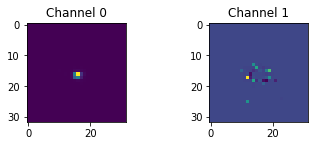

In [16]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0")
plt.grid(False)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1")
plt.grid(False)


plt.show()

Convolution, max pooling, UpSampling,  respectively., max pooling, Conv, Dropout, Conv, Flaten, Dense, Dense, Dropout.


In [ ]:
model = Sequential()

model.add(Conv2D(32, activation='relu', kernel_size=(5,5),  padding='same',input_shape=(img_rows, img_cols, nb_channels)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, activation='relu', padding='same',kernel_size=(3,3), kernel_initializer='TruncatedNormal'))

#Upsampling with size 2 and default ordering: Repeats the rows and columns of the data by size[0] and size[1], The idea was to enhance any assymetry in the pictures by repeated sampling
model.add(UpSampling2D(size=(2, 2), dim_ordering='default'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', padding='same',kernel_size=3, kernel_initializer='VarianceScaling'))
model.add(Dropout(0.2))
model.add(Conv2D(32, activation='relu', padding='same',kernel_size=2, kernel_initializer='TruncatedNormal'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='VarianceScaling')) #relu
model.add(Dropout(0.2))


model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal')) #relu
model.add(Dropout(0.2))

model.add(Dense(1, activation='hard_sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

Train the datasets:

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.1, patience=10, min_lr=1e-7) #val_loss #acc,loss,val_acc,val_loss,lr
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr, early],\
        verbose=1, shuffle=True)

Train on 128000 samples, validate on 60048 samples
Epoch 1/10
128000/128000 [==============================] - 719s 6ms/step - loss: 0.6707 - acc: 0.5867 - val_loss: 0.6540 - val_acc: 0.6129
Epoch 2/10
128000/128000 [==============================] - 710s 6ms/step - loss: 0.6562 - acc: 0.6123 - val_loss: 0.6508 - val_acc: 0.6174
Epoch 3/10
128000/128000 [==============================] - 701s 5ms/step - loss: 0.6498 - acc: 0.6208 - val_loss: 0.6466 - val_acc: 0.6238
Epoch 4/10
128000/128000 [==============================] - 719s 6ms/step - loss: 0.6495 - acc: 0.6228 - val_loss: 0.6439 - val_acc: 0.6284
Epoch 5/10
128000/128000 [==============================] - 717s 6ms/step - loss: 0.6551 - acc: 0.6150 - val_loss: 0.6461 - val_acc: 0.6295
Epoch 6/10
128000/128000 [==============================] - 726s 6ms/step - loss: 0.6435 - acc: 0.6331 - val_loss: 0.6409 - val_acc: 0.6327
Epoch 7/10
128000/128000 [==============================] - 667s 5ms/step - loss: 0.6387 - acc: 0.6383 - val_

In [19]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

60048/60048 [==============================] - 95s 2ms/step

Validation loss / accuracy: 0.6198 / 0.6599
Validation ROC AUC: 0.718454894579762
20100/20100 [==============================] - 31s 2ms/step

Test loss / accuracy: 0.6202 / 0.6586
Test ROC AUC: 0.7169795104081582


No handles with labels found to put in legend.


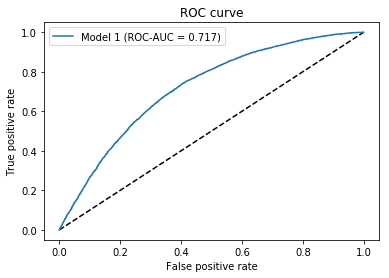

In [20]:
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()